In [1]:
import random
import time
import os

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt

Ref: Section 7 (Appendix) from CycleGAN

## Generator Architecture

In [14]:
# CINR = Convolution Instance Norm ReLU
# 3x3 convolutions with stride 1/2, 1 or 2 depending on position
# Uses reflection padding
# In the paper:
# dk denotes a k filter stride 2 with 3x3 conv
# c7s1-k denotes a k filter stride 1 with 7x7 conv
# uk denotes a k filter stride 1/2 with 3x3 conv
# Instead of using a nn.Module, this has much less overhead
def createGeneratorCINRLayer(in_ch, out_ch, stride, kernel_size, reflect_pad):
    layers = []
        
    padding = 1
    
    if reflect_pad:
        layers.append(nn.ReflectionPad2d(kernel_size // 2))
        padding = 0

    if stride < 1:
        layers.append(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=int(1 / stride), padding=padding, output_padding=padding, bias=True)
        )
    else:
        layers.append(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        )
    
    layers += [
        nn.InstanceNorm2d(out_ch),
        nn.ReLU(True)
    ]

    return nn.Sequential(*layers)

In [15]:
# Contains 2 3x3 convolutional layers with the same number of filters on both layers
# Use reflect padding in these
# Don't use dropout
# Use instancenorm
class GeneratorResidualBlock(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(feature_size, feature_size, kernel_size=3, bias=True),
            nn.InstanceNorm2d(feature_size),
            nn.ReLU(True),
            # Dropout would go here if I want it
            nn.ReflectionPad2d(1),
            nn.Conv2d(feature_size, feature_size, kernel_size=3, bias=True)
        ]
        
        self.seq = nn.Sequential(*layers)
    
    def forward(self, batch):
        return batch + self.seq(batch)

In [16]:
# For the 128x128 case:
# c7s1-64, d128, d256, R256 x 6, u128, u64, c7s1-3
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        layers = [
            createGeneratorCINRLayer(in_ch=3, out_ch=64, stride=1, kernel_size=7, reflect_pad=True),
            createGeneratorCINRLayer(in_ch=64, out_ch=128, stride=2, kernel_size=3, reflect_pad=False),
            createGeneratorCINRLayer(in_ch=128, out_ch=256, stride=2, kernel_size=3, reflect_pad=False),
            
            # same dim all the way through
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            
            createGeneratorCINRLayer(in_ch=256, out_ch=128, kernel_size=3, stride=0.5, reflect_pad=False),
            createGeneratorCINRLayer(in_ch=128, out_ch=64, kernel_size=3, stride=0.5, reflect_pad=False),

            # Last one is a bit different without the ReLU and instance norm
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=64, out_channels=3, stride=1, kernel_size=7, bias=True),
            nn.Tanh()
        ]
        
        self.seq = nn.Sequential(*layers)
        
    def forward(self, batch):
        return self.seq(batch)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if (torch.cuda.device_count()>0):
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce GTX 1080


TODO: Initialise the weights \\
TODO: PatchGAN \\
TODO: Put altogther into CycleGAN \\
TODO: Loss functions \\
TODO: Optimiser scheduler \\
TODO: History buffer \\
TODO: Generalise CINR layer to work for both discriminator and generator?

## PatchGAN

In [17]:
# CINR = Convolution Instance Normalisation Layer
# Denoted Ck where k = #filters
def createDiscriminatorCINRLayer(in_ch, out_ch, stride, apply_norm):
    layers = [
        nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=stride, padding=1),
    ]

    if apply_norm:
        layers.append(
            nn.InstanceNorm2d(out_ch)
        )
    
    layers.append(
        nn.LeakyReLU(0.2, True)
    )

    return nn.Sequential(*layers)

In [18]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        layers = [
            createDiscriminatorCINRLayer(in_ch=3, out_ch=64, stride=2, apply_norm=False),
            createDiscriminatorCINRLayer(in_ch=64, out_ch=128, stride=2, apply_norm=True),
            createDiscriminatorCINRLayer(in_ch=128, out_ch=256, stride=2, apply_norm=True),
            createDiscriminatorCINRLayer(in_ch=256, out_ch=512, stride=1, apply_norm=True),
            # In the source of CycleGAN they use k=4, s=1, p=1 despite not saying this in the paper
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.seq = nn.Sequential(*layers)

    def forward(self, batch):
        return self.seq(batch)

In [19]:
class HistoryBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
        
    def __len__(self):
        return len(self.buffer)

    def _make_space(self, max_del_size):
        current_available_space = self.max_size - len(self)
        del_size = max(0, max_del_size - current_available_space)

        if del_size == 0:
            return

        del_indexes = random.sample(range(0, len(self)), del_size)

        for del_idx in del_indexes:
            del self.buffer[del_idx]

    def add(self, batch):
        self._make_space(len(batch))

        for item in batch:
            self.buffer.append(item.detach().cpu())

    def sample_batch(self, batch_size):
        return torch.stack(random.sample(self.buffer, batch_size))

    def randomise_existing_batch(self, existing_batch):
        if len(self) < existing_batch.shape[0] / 2:
            return existing_batch
        
        new_batch = []

        for item in existing_batch:
            if random.uniform(0, 1) < 0.5:
                new_batch.append(item.detach().cpu())
            else:
                new_batch.append(self.buffer[random.randint(0, len(self) - 1)])

        return torch.stack(new_batch)

1. Translate real images from X to Y and then back again from Y to X (call these fake_Y, cycled_X)
2. Translate real images from Y to X and then back again from X to Y (call these fake_X, cycled_Y)
3. Disable gradients on discriminators, then backprop and optimise the generators
4. Disable gradients on generators (re-enable on dis!), then backprop and optimise the discriminators

In [20]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.data = []
        
        tensor_transform = transforms.ToTensor()
        
        for file_name in os.listdir(folder):
            img = Image.open(f"{folder}/{file_name}").convert("RGB")
            tensored = tensor_transform(img)
            self.data.append(tensored)
            
        self.real_length = len(self.data)
        self.forced_length = len(self.data)
    
    def __getitem__(self, index):
        # May be better to randomise if index > self.real_length ?
        return self.data[index % self.real_length]
    
    def __len__(self):
        return self.forced_length

In [21]:
X_dataset = ImageDataset("./cyclegan_original_data/horse2zebra/testA")

In [22]:
Y_dataset = ImageDataset("./cyclegan_original_data/horse2zebra/testB")

In [23]:
loc = "./runs/1677670890.2960796/25"

In [24]:
G = Generator()
G.load_state_dict(torch.load(f"{loc}/G_A.pth"))
G = G.eval().to(device)

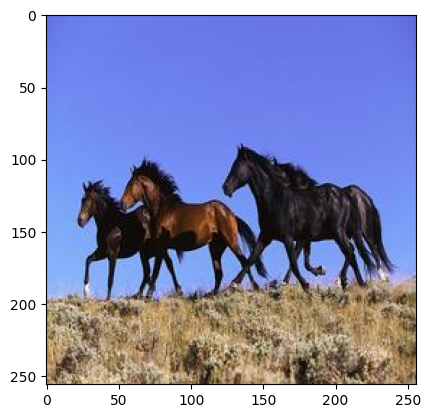

In [25]:
G_inp = X_dataset.data[random.randint(0, X_dataset.real_length)]
plt.imshow(G_inp.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


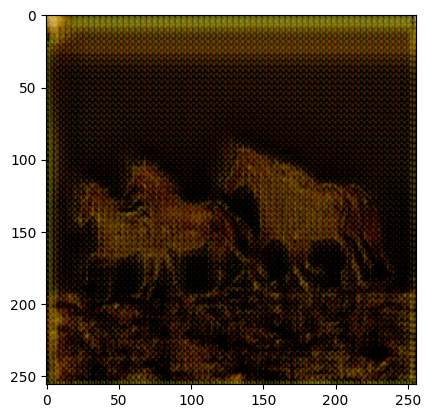

In [26]:
with torch.no_grad():
    G_forward = G(G_inp.to(device).unsqueeze(dim=0))
    
G_forward = G_forward.squeeze().cpu()
plt.imshow(G_forward.permute(1, 2, 0))

In [ ]:
F = Generator()
F.load_state_dict(torch.load(f"{loc}/G_B.pth"))
F = F.eval().to(device)

In [ ]:
F_inp = Y_dataset.data[random.randint(0, Y_dataset.real_length)]
plt.imshow(F_inp.permute(1, 2, 0))

In [ ]:
with torch.no_grad():
    F_forward = F(F_inp.to(device).unsqueeze(dim=0))
    
F_forward = F_forward.squeeze().cpu()
plt.imshow(F_forward.permute(1, 2, 0))